## Detalhes técnicos:

Transformação PCA: A descrição dos dados diz que todos os recursos sofreram uma transformação PCA (técnica de Redução de Dimensionalidade) (Exceto tempo e quantidade).

Dimensionamento: Para implementar uma transformação PCA os recursos necessitam de ser previamente dimensionados. Neste caso, todos os recursos V foram dimensionados.

### Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import time
from scipy.stats import norm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
sys.path.append(os.path.join(os.getcwd(), 'etl', 'pipeline'))


### Extrair dataset


In [2]:
#!{sys.executable} -m pip install python-dotenv
from extract import download_dataset

dataset_name = "mlg-ulb/creditcardfraud"
dataset_path = "data"
download_dataset(dataset_name, dataset_path)

Dataset mlg-ulb/creditcardfraud baixado com sucesso em `data!


In [3]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Análise do Dataset

Não há valores faltantes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


O valor da transação é relativamente pequeno. A média de todas as montagens realizadas é de aproximadamente 88 dólares.

In [6]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Qual o percentual de transações que são fraudes?

In [7]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

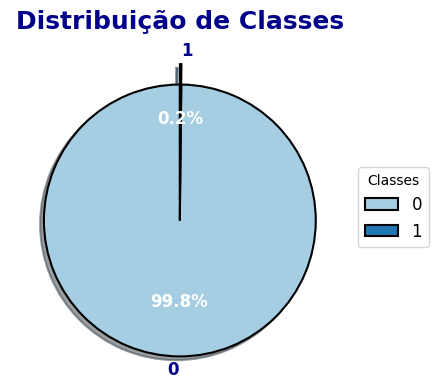

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(aspect="equal"))

value_counts = data['Class'].value_counts()
colors = plt.cm.Paired(range(len(value_counts)))

explode = [0.1 if i == value_counts.idxmax() else 0.05 for i in value_counts.index]

wedges, texts, autotexts = ax.pie(
    value_counts,
    labels=value_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    textprops=dict(color="darkblue", fontsize=12)
)

plt.setp(autotexts, size=12, weight="bold", color="white")
plt.setp(texts, size=12, weight="bold")
ax.legend(wedges, value_counts.index,
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=12)

ax.set_title("Distribuição de Classes", fontsize=18, fontweight='bold', color="darkblue")

plt.tight_layout()

plt.show()

A maioria das transações foi "Não Fraude" em (99,8%) das vezes, enquanto as transações "Fraude" ocorrem (0,2%) das vezes no dataframe.

### Distribuições

C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\2925254974.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(amount_val, ax=ax[0], color='r')
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\2925254974.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_val, ax=ax[1]

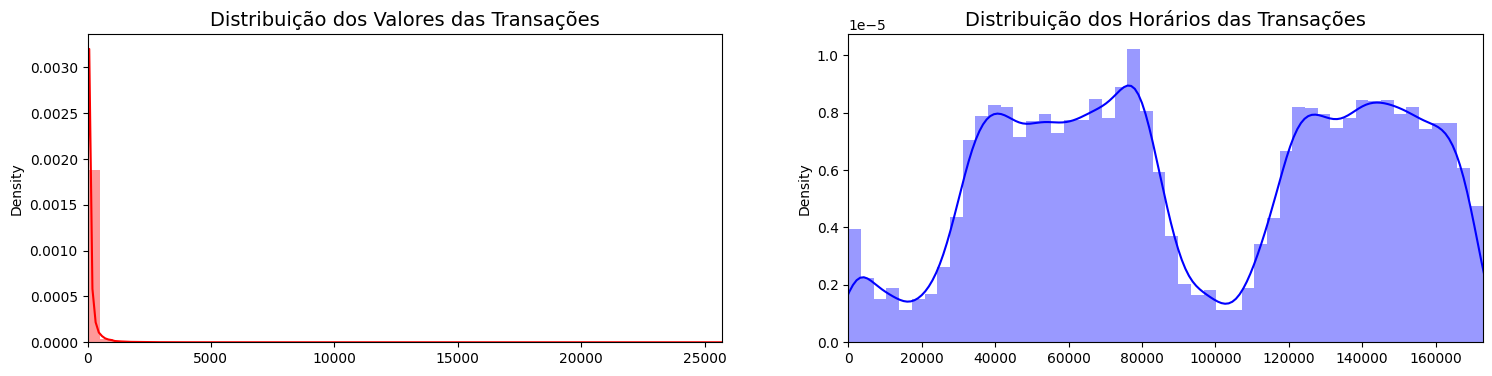

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# armazena os valores das colunas em uma variável 

amount_val = data['Amount'].values 
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribuição dos Valores das Transações', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribuição dos Horários das Transações', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

### Dimensionamento e Distribuição

O tempo e o valor devem ser dimensionados como as outras colunas. Também é necessário criar uma subamostra do dataframe para termos uma quantidade igual de casos de Fraude e Não Fraude, ajudando os algoritmos a compreenderem melhor os padrões que determinam se uma transação é uma fraude ou não.

Neste cenário, a subamostra será um dataframe com uma proporção de 50/50 de transações fraudulentas e não fraudulentas. Isto significa que a subamostra terá a mesma quantidade de transações fraudulentas e não fraudulentas. Isso ajuda a melhorar o dataset desbalanceado.

RobustScaler ajuda a tornar os dados mais estáveis, principalmente quando há valores extremos (outliers)

- reshape(-1, 1) serve para transformar uma sequência de números (um vetor de 1D) em uma matriz com uma coluna e várias linhas, ou seja, uma matriz de 2 dimensões. Isso é necessário porque a maioria dos algoritmos de aprendizado de máquina e pré-processamento, como o RobustScaler, espera dados no formato de matriz. Isso é necessário para que as funções de pré-processamento, como o fit_transform, funcionem corretamente

In [10]:
# !{sys.executable} -m pip install scikit-learn
from transform import transform_data

data = transform_data(data)
data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting Dataset

StratifiedShuffleSplit: Uma maneira de dividir os dados em múltiplos conjuntos de treino e teste, mas garantindo que a distribuição das classes (fraude e não fraude) seja proporcional em ambos os conjuntos.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

X = data.drop('Class', axis=1)
y = data['Class']

- StratifiedKFold: Divide os dados de forma estratificada em 5 partes, nesse caso as distribuições das classes são proporcionais em cada divisão
- shuffle=False: Os dados não serão embaralhados antes de dividir. Caso fosse True, os dados seriam misturados aleatoriamente.

In [12]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)

    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [13]:
# Transforma em Array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [14]:
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Distribuicoes: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


Distribuicoes: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling

Remover dados para termos um conjunto de dados mais equilibrado e assim evitar que os nossos modelos sofram overfitting. A primeira coisa que temos de fazer é determinar o quão desequilibrada está a nossa classe. Depois de determinarmos quantas instâncias são consideradas transações fraudulentas devemos trazer as transações não fraudulentas para o mesmo valor das transações fraudulentas. Após a implementação desta técnica, temos uma subamostra do nosso dataframe com um rácio de 50/50 em relação às nossas classes. Assim, o próximo passo que implementaremos é embaralhar os dados para ver se os nossos modelos conseguem manter uma certa precisão sempre que executarmos este script.

In [15]:
# embaralhando as linhas do dataframe

data = data.sample(frac=1)

# filtrando as classes de fraude e não fraude

fraude = data.loc[data['Class'] == 1]
nao_fraude = data.loc[data['Class'] == 0][:492] # vai conter somente as 492 linhas e isso é feito para igualar o numero de fraudes e nao fraudes

In [16]:
# criando dataframe balanceado

normal_distributed = pd.concat([fraude, nao_fraude]) # unidas em um unico dataframe

# embaralhando novamente

normal_distributed = normal_distributed.sample(frac=1, random_state=42)

normal_distributed.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
274326,12.254594,0.954746,0.497891,-3.579021,-2.202132,-0.041862,-1.558152,-0.947046,0.835022,-0.562582,...,1.708627,0.493985,-0.552604,-0.552775,0.008024,-0.413355,-0.418322,-0.203340,0.091928,0
15810,1.089779,-0.674820,-25.942434,14.601998,-27.368650,6.378395,-19.104033,-4.684806,-18.261393,17.052566,...,1.667304,1.784316,-1.917759,-1.235787,0.161105,1.820378,-0.219359,1.388786,0.406810,1
107726,-0.286732,-0.165756,1.087098,0.460868,0.840191,2.368667,-0.157365,0.114081,-0.117683,0.225088,...,-0.243629,-0.168158,-0.607361,0.200050,0.139309,0.086711,-0.262698,0.000424,0.014811,0
18472,-0.297911,-0.648046,-1.060676,2.608579,-2.971679,4.360089,3.738853,-2.728395,1.987616,-0.357345,...,-0.089062,-0.063168,-0.207385,-0.183261,-0.103679,0.896178,0.407387,-0.130918,0.192177,1
82400,-0.042199,-0.297313,-7.626924,-6.976420,-2.077911,3.416754,4.458758,-5.080408,-6.578948,1.760341,...,2.875260,1.224795,-0.656639,-0.330811,-0.078946,0.270306,0.431119,0.821381,-1.056088,1


Distribuicao das Classes na subamostra
Class
0    0.5
1    0.5
Name: count, dtype: float64


C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\1639523048.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=normal_distributed, palette=colors)
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\1639523048.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.countplot(x='Class', data=normal_distributed, palette=colors)


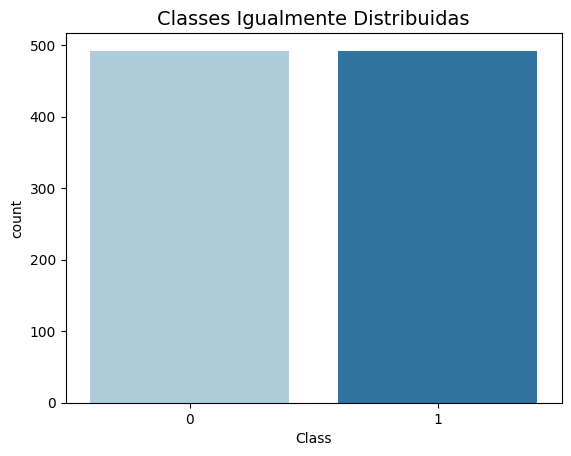

In [17]:
print("Distribuicao das Classes na subamostra")

print(normal_distributed['Class'].value_counts() / len(normal_distributed))

sns.countplot(x='Class', data=normal_distributed, palette=colors)
plt.title('Classes Igualmente Distribuidas', fontsize=14)
plt.show()

### Matriz de Correlação

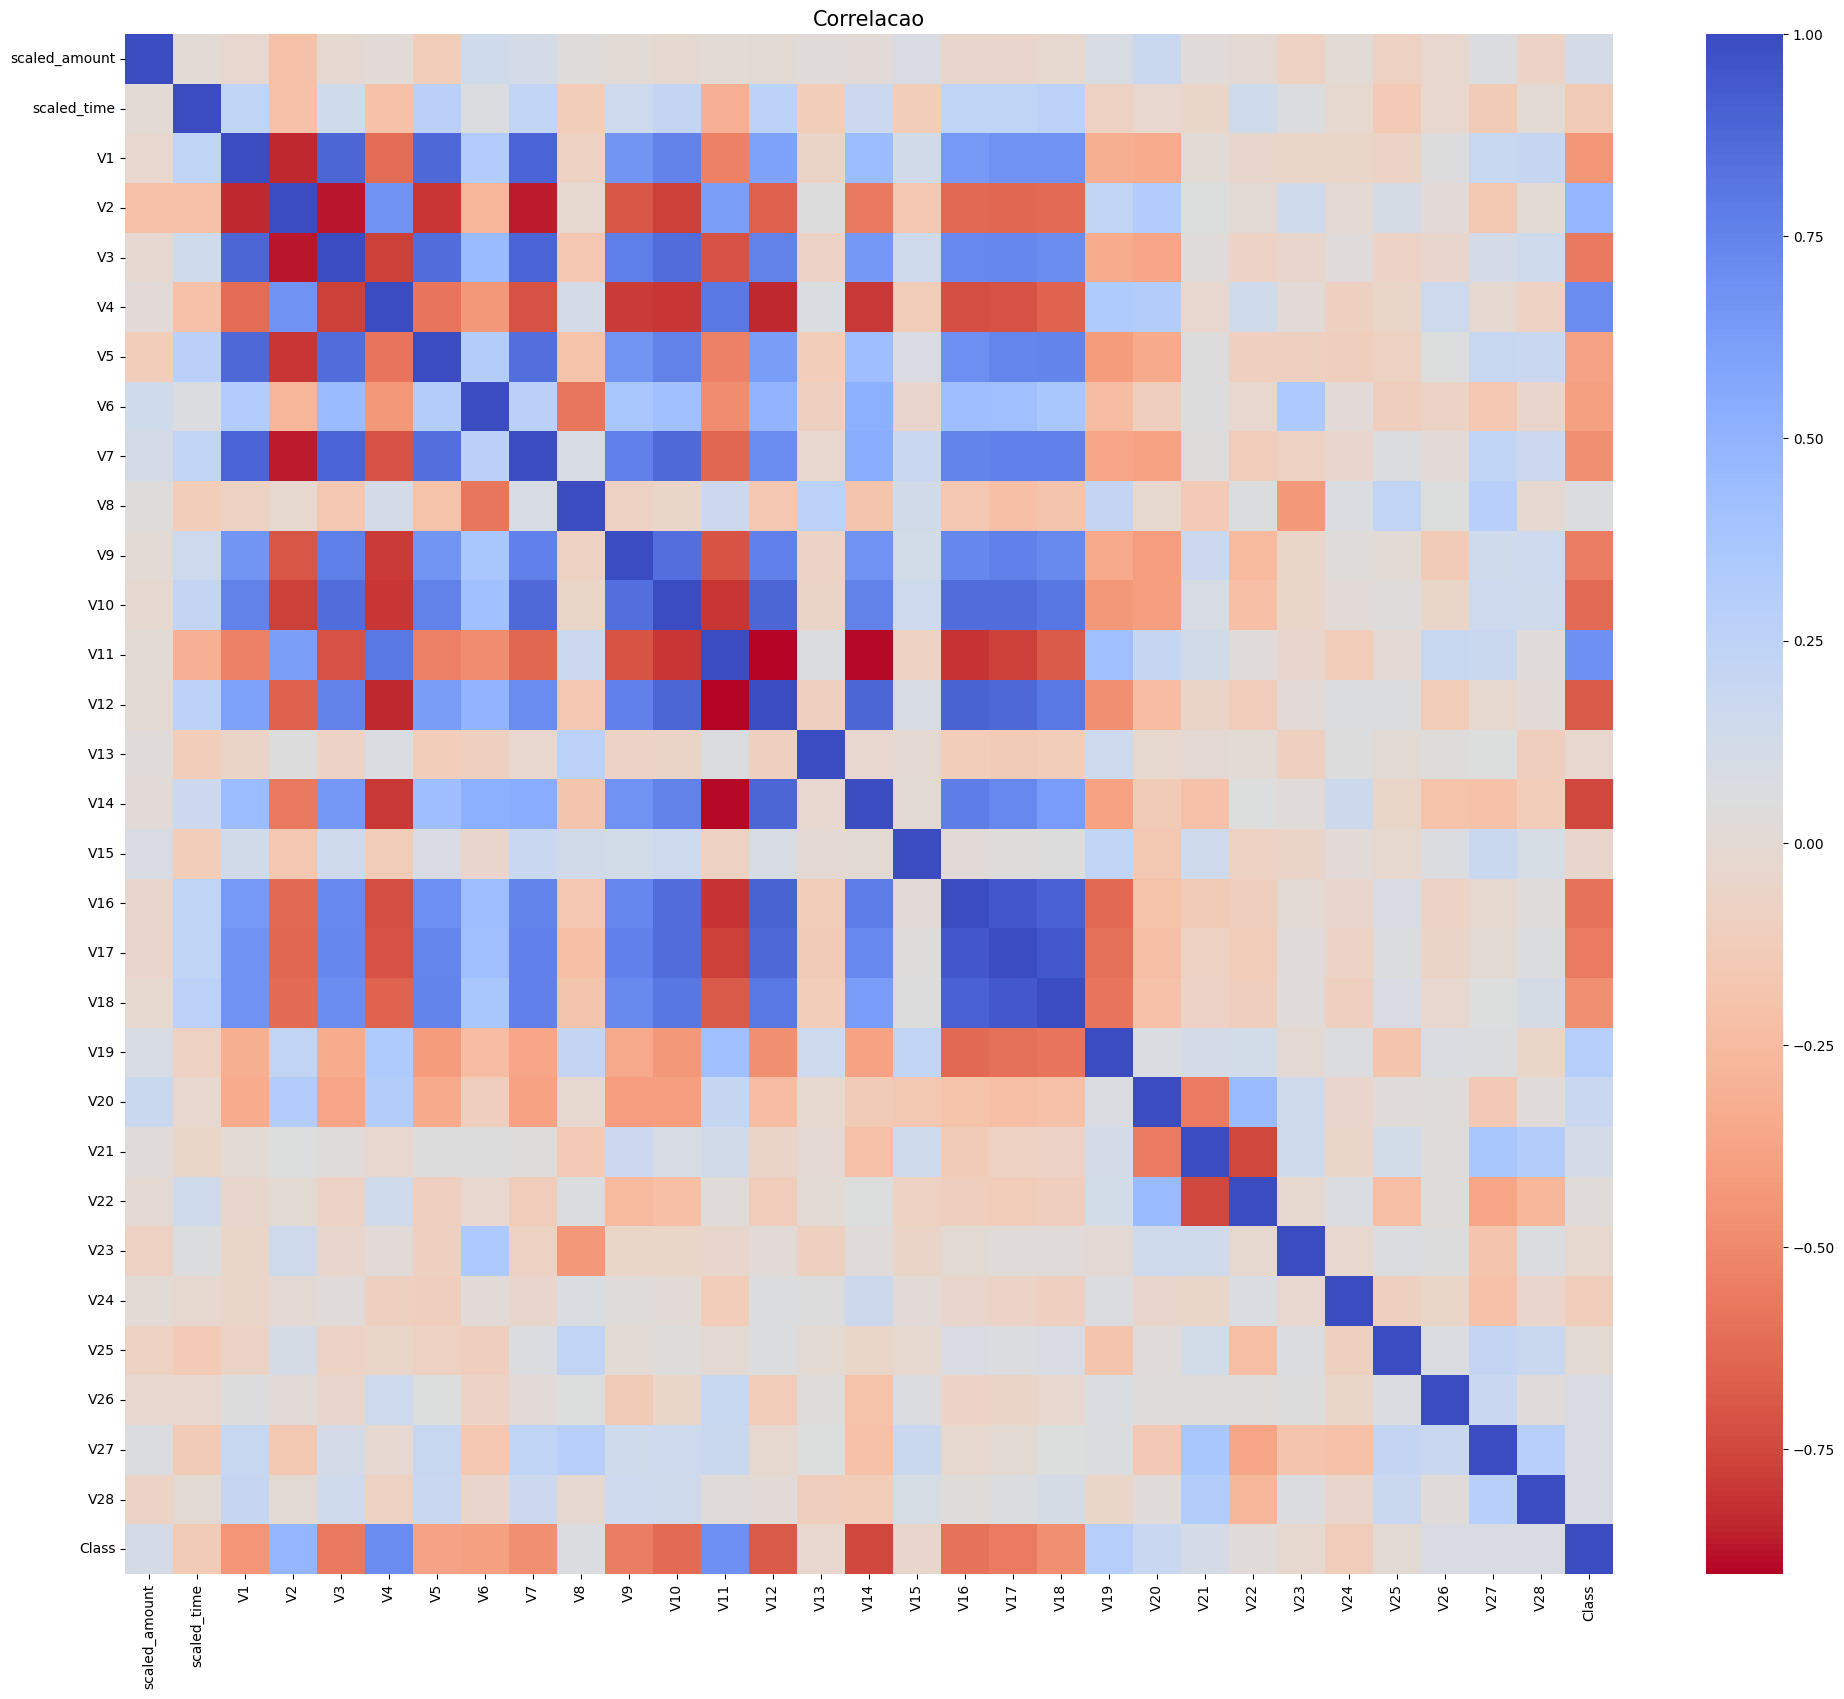

In [18]:
plt.figure(figsize=(24, 20))

corr = normal_distributed.corr()

sns.heatmap(corr, cmap='coolwarm_r', annot=False)

plt.title('Correlacao', fontsize=15)
plt.show()

C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\2857674271.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V17", data=normal_distributed, palette=colors, ax=axes[0])
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\2857674271.py:3: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x="Class", y="V17", data=normal_distributed, palette=colors, ax=axes[0])
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\2857674271.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=normal_distributed, palette=colors, ax=axes[1])
C:\User

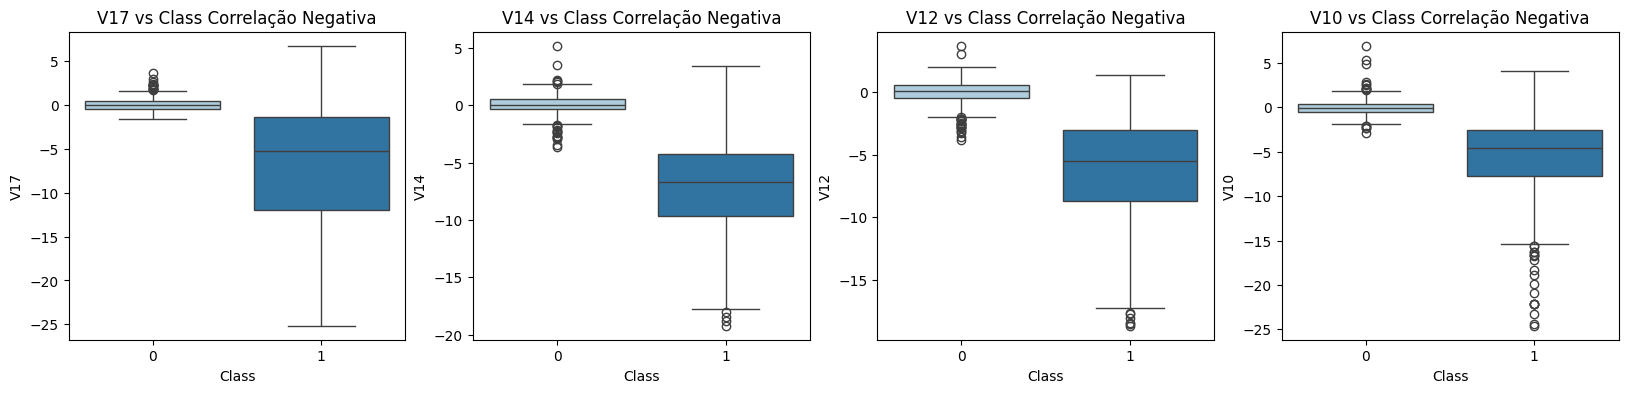

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=normal_distributed, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Correlação Negativa')

sns.boxplot(x="Class", y="V14", data=normal_distributed, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Correlação Negativa')


sns.boxplot(x="Class", y="V12", data=normal_distributed, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Correlação Negativa')


sns.boxplot(x="Class", y="V10", data=normal_distributed, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Correlação Negativa')

plt.show()

C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\932538399.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V11", data=normal_distributed, palette=colors, ax=axes[0])
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\932538399.py:3: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x="Class", y="V11", data=normal_distributed, palette=colors, ax=axes[0])
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\932538399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V4", data=normal_distributed, palette=colors, ax=axes[1])
C:\Users\Be

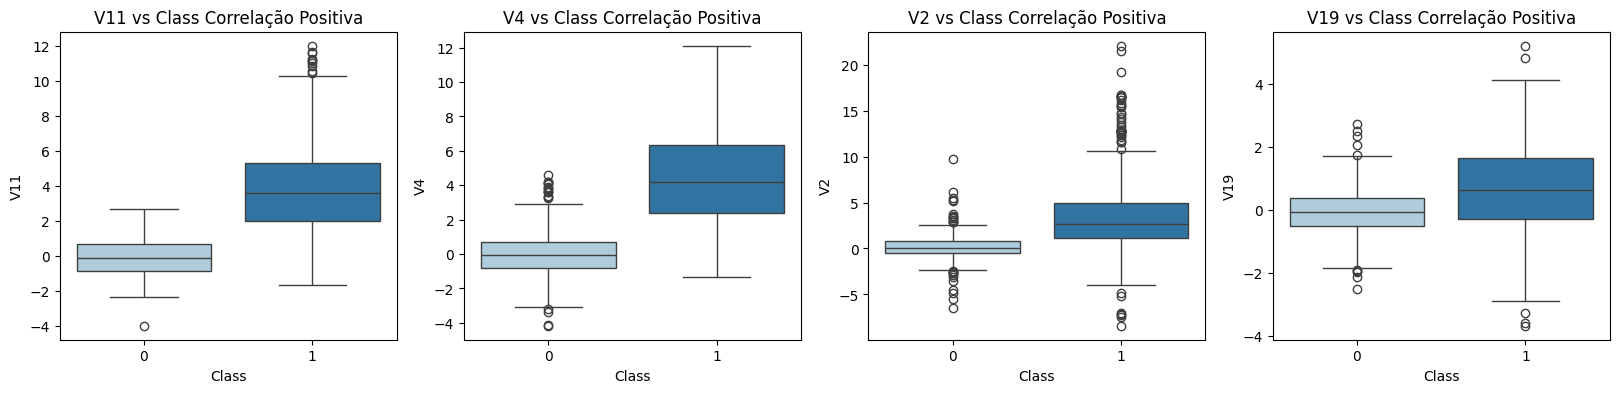

In [20]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=normal_distributed, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Correlação Positiva')

sns.boxplot(x="Class", y="V4", data=normal_distributed, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Correlação Positiva')


sns.boxplot(x="Class", y="V2", data=normal_distributed, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Correlação Positiva')


sns.boxplot(x="Class", y="V19", data=normal_distributed, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Correlação Positiva')

plt.show()

### Detecção de Anomalias

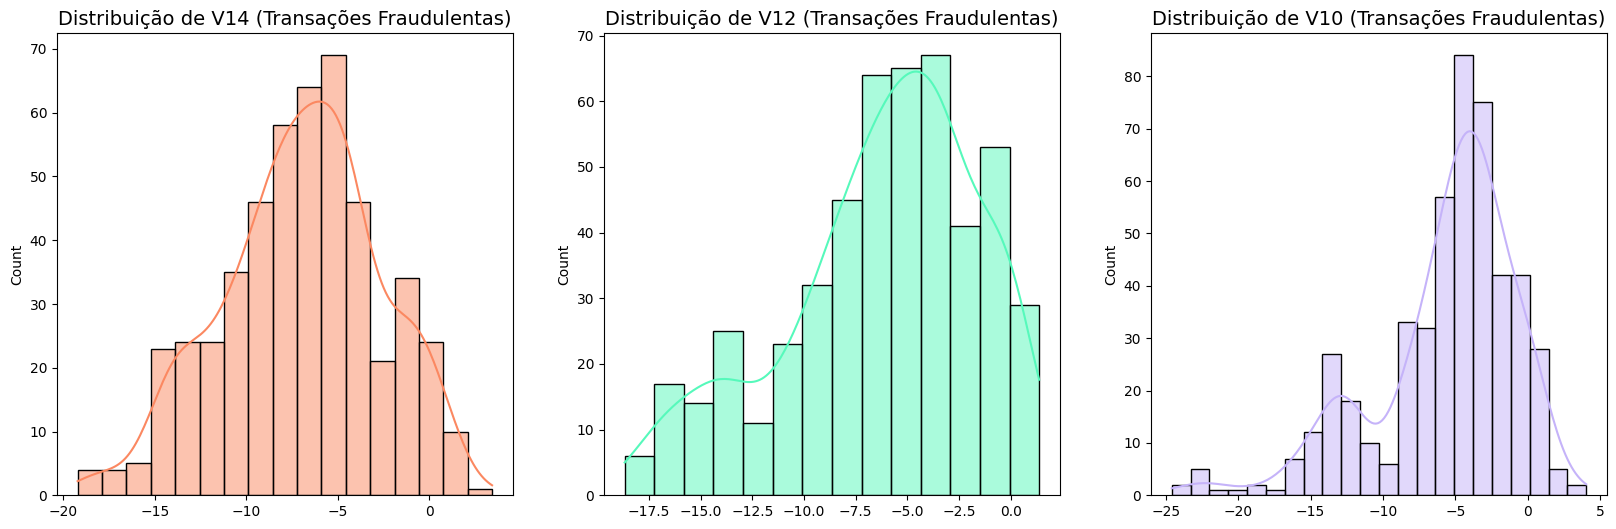

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# filtrando apenas transações fraudulentas
v14_fraud_dist = data['V14'].loc[data['Class'] == 1].values
v12_fraud_dist = data['V12'].loc[data['Class'] == 1].values
v10_fraud_dist = data['V10'].loc[data['Class'] == 1].values

# gráfico de distribuição para V14
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, color='#FB8861')
ax1.set_title('Distribuição de V14 (Transações Fraudulentas)', fontsize=14)

# gráfico de distribuição para V12
sns.histplot(v12_fraud_dist, ax=ax2, kde=True, color='#56F9BB')
ax2.set_title('Distribuição de V12 (Transações Fraudulentas)', fontsize=14)

# gráfico de distribuição para V10
sns.histplot(v10_fraud_dist, ax=ax3, kde=True, color='#C5B3F9')
ax3.set_title('Distribuição de V10 (Transações Fraudulentas)', fontsize=14)

plt.show()

C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\1622949368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=data, ax=ax1, palette=colors)
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\1622949368.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=data, ax=ax2, palette=colors)
C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_12636\1622949368.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V10", data=data, ax=ax3, palette=colors)


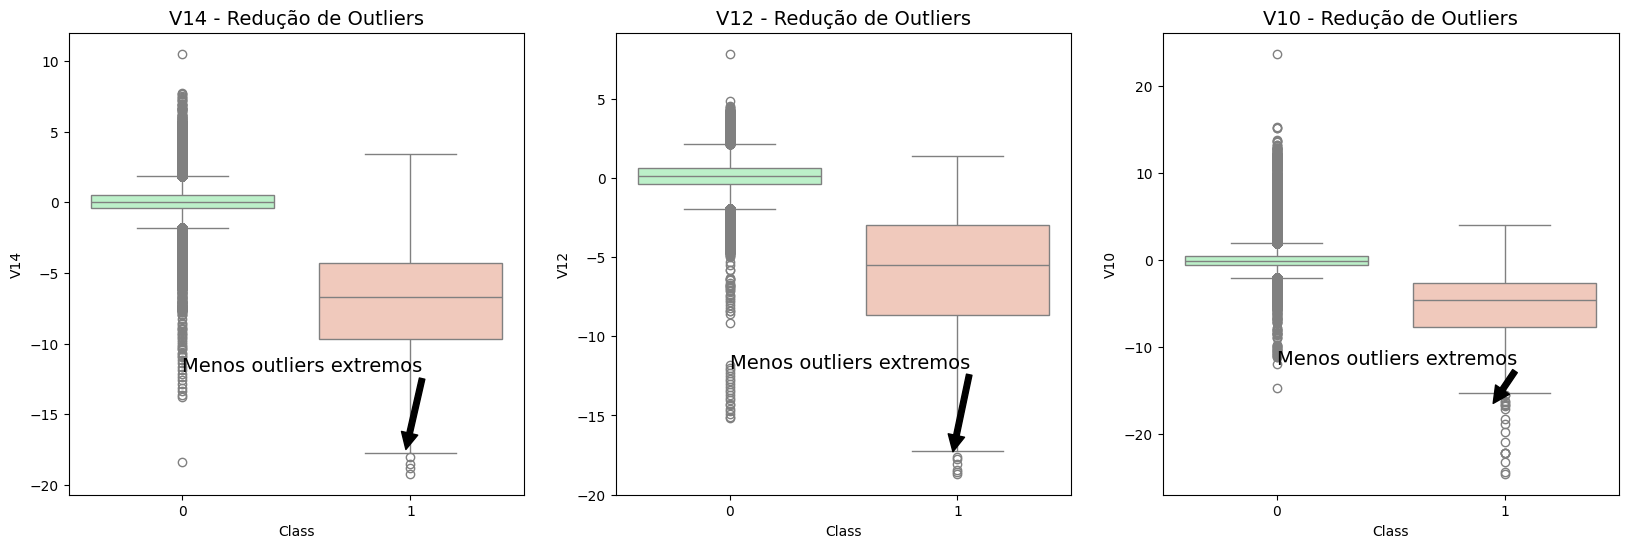

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# definição das cores para as classes (fraude e não fraude)
colors = ['#B3F9C5', '#f9c5b3']

sns.boxplot(x="Class", y="V14", data=data, ax=ax1, palette=colors)
ax1.set_title("V14 - Redução de Outliers", fontsize=14)
ax1.annotate('Menos outliers extremos', xy=(0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'), fontsize=14)

sns.boxplot(x="Class", y="V12", data=data, ax=ax2, palette=colors)
ax2.set_title("V12 - Redução de Outliers", fontsize=14)
ax2.annotate('Menos outliers extremos', xy=(0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor='black'), fontsize=14)

sns.boxplot(x="Class", y="V10", data=data, ax=ax3, palette=colors)
ax3.set_title("V10 - Redução de Outliers", fontsize=14)
ax3.annotate('Menos outliers extremos', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'), fontsize=14)

plt.show()

### Redução de Dimensionalidade e Clusterização

Ter muitas colunas pode dificultar a visualização e até atrapalhar o desempenho de alguns modelos. Reduzindo para apenas 2 dimensões conseguimos visualizar melhor os dados e manter as informações mais importantes.

In [23]:
X = data.drop('Class', axis=1) 
y = data['Class']  

#### PCA pega as direções onde os dados variam mais e reduz as dimensões mantendo o máximo de informação possível. É rápido e muito usado, mas pode não capturar bem padrões complexos.



In [24]:
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA levou {:.2} s".format(t1 - t0))

PCA levou 0.08 s


#### Truncated SVD é parecido com PCA, mas funciona melhor com dados esparsos (muitas colunas com valores zero). É rápido e eficiente.

In [25]:
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD levou {:.2} s".format(t1 - t0))

Truncated SVD levou 0.9 s


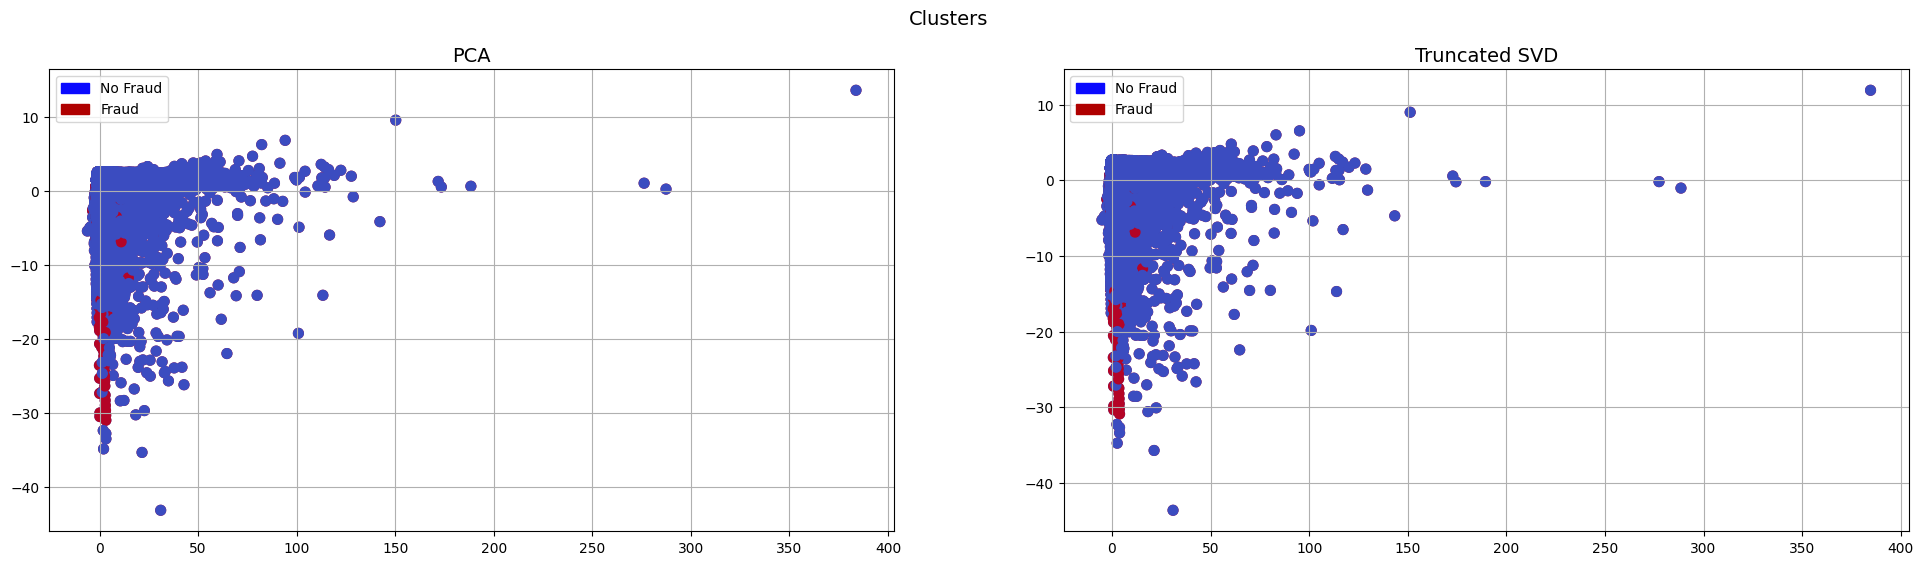

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
f.suptitle('Clusters', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# PCA 
ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('PCA', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# TruncatedSVD 
ax2.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('Truncated SVD', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

plt.show()

### Modelos de Classsificação

In [27]:
X = data.drop('Class', axis=1)
y = data['Class']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier()
}

In [30]:
print("Resultados Base:")
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.2%}")

Resultados Base:
LogisticRegression: 99.92%
KNearest: 99.95%
DecisionTree: 99.92%


In [31]:
# otimização com GridSearchCV
param_grids = {
    "LogisticRegression": {'C': [0.1, 1, 10], 'penalty': ['l2']},
    "KNearest": {'n_neighbors': [3, 5, 7], 'algorithm': ['auto']},
    "DecisionTree": {'max_depth': [3, 5], 'criterion': ['gini', 'entropy']}
}

best_models = {}
for name in classifiers:
    grid = GridSearchCV(classifiers[name], param_grids[name], cv=3)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"\nMelhores parâmetros para {name}:")
    print(grid.best_params_)


Melhores parâmetros para LogisticRegression:
{'C': 10, 'penalty': 'l2'}

Melhores parâmetros para KNearest:
{'algorithm': 'auto', 'n_neighbors': 3}

Melhores parâmetros para DecisionTree:
{'criterion': 'entropy', 'max_depth': 5}


In [32]:
# avaliação dos modelos otimizados
print("\nResultados Otimizados:")
for name, model in best_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} ROC AUC: {scores.mean():.2%}")


Resultados Otimizados:
LogisticRegression ROC AUC: 97.35%
KNearest ROC AUC: 91.87%
DecisionTree ROC AUC: 91.90%


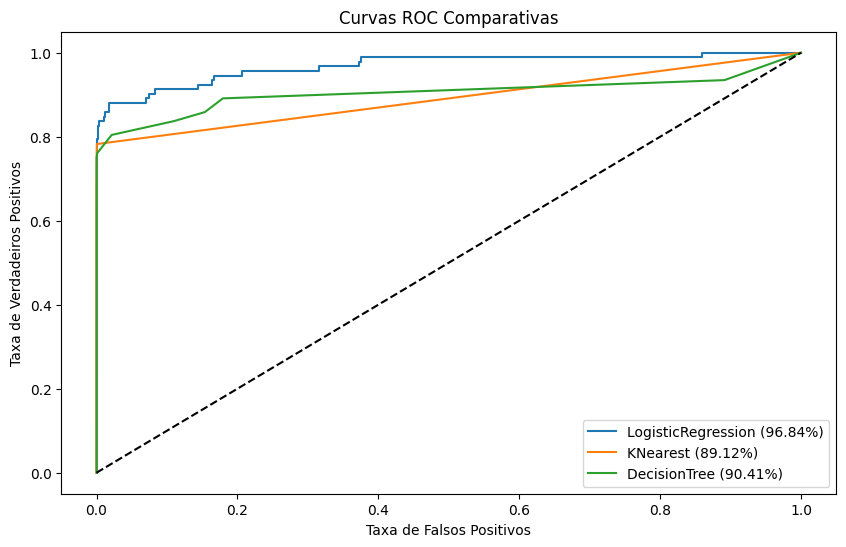

In [33]:
# curvas ROC
plt.figure(figsize=(10, 6))
for name, model in best_models.items():
    probas = model.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    plt.plot(fpr, tpr, label=f'{name} ({roc_auc_score(y_test, probas):.2%})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC Comparativas')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()

In [34]:
# undersampling com NearMiss
pipeline = imbalanced_make_pipeline(NearMiss(), LogisticRegression())
scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
print(f"\nRecall com Undersampling: {scores.mean():.2%}")


Recall com Undersampling: 94.10%


In [35]:
# SMOTE (Oversampling)
from imblearn.over_sampling import SMOTE

smote_pipeline = imbalanced_make_pipeline(SMOTE(), LogisticRegression())
scores = cross_val_score(smote_pipeline, X, y, cv=5, scoring='recall')
print(f"Recall com SMOTE: {scores.mean():.2%}")

Recall com SMOTE: 91.26%


In [36]:
# relatório final do melhor modelo
best_model = best_models['LogisticRegression']
best_model.fit(X_train, y_train)
print("\nRelatório de Classificação Final:")
print(classification_report(y_test, best_model.predict(X_test)))


Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56870
           1       0.93      0.55      0.69        92

    accuracy                           1.00     56962
   macro avg       0.96      0.78      0.85     56962
weighted avg       1.00      1.00      1.00     56962

